# This is the practice for logistic regression
# Goals:
## 1 - Fit logistic model (Sklearn and GLM- statsmodel)
## 2 - KPIs to evaluate binary classification model(logistic model)

In [48]:
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression #, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score

import statsmodels.api as sm


from dmba import classificationSummary

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

Define paths to data sets. 

In [49]:
DATA = Path('.').resolve().parents[1] / 'Practice\logit'
LOAN3000_CSV = DATA / 'loan3000.csv'
# LOAN_DATA_CSV = DATA / 'loan_data.csv.gz'

### Load Data and EDA

In [50]:
loan_data = pd.read_csv(LOAN3000_CSV)
print(loan_data.shape)
print(loan_data.columns)
print(loan_data.head())

(3000, 6)
Index(['Unnamed: 0', 'outcome', 'purpose_', 'dti', 'borrower_score',
       'payment_inc_ratio'],
      dtype='object')
   Unnamed: 0   outcome            purpose_    dti  borrower_score  \
0       32109  paid off  debt_consolidation  21.23            0.40   
1       16982   default         credit_card  15.49            0.40   
2       25335  paid off  debt_consolidation  27.30            0.70   
3       34580  paid off      major_purchase  21.11            0.40   
4       14424   default  debt_consolidation  16.46            0.45   

   payment_inc_ratio  
0            5.11135  
1            5.43165  
2            9.23003  
3            2.33482  
4           12.10320  


##### Task: Create 'dv' before run the cell

In [51]:
loan_data.outcome.unique()

array(['paid off', 'default'], dtype=object)

In [52]:
loan_data = loan_data.drop(loan_data.columns[0], axis=1).copy()
loan_data.columns=['outcome', 'purpose', 'dti', 'borrower_score', 'payment_inc_ratio']

#PLEASE USE LIST Comprehension to convert nominal 'outcome' to binary numerical column
loan_data['dv'] = loan_data.outcome.apply(lambda x: 0 if x == "default" else 1)

print(loan_data.shape)
print(loan_data.columns)
print(loan_data.head())

(3000, 6)
Index(['outcome', 'purpose', 'dti', 'borrower_score', 'payment_inc_ratio',
       'dv'],
      dtype='object')
    outcome             purpose    dti  borrower_score  payment_inc_ratio  dv
0  paid off  debt_consolidation  21.23            0.40            5.11135   1
1   default         credit_card  15.49            0.40            5.43165   0
2  paid off  debt_consolidation  27.30            0.70            9.23003   1
3  paid off      major_purchase  21.11            0.40            2.33482   1
4   default  debt_consolidation  16.46            0.45           12.10320   0


In [53]:
for nm in loan_data.columns:
    print("\n{}".format(nm))
    print(loan_data[nm].value_counts())


outcome
paid off    1555
default     1445
Name: outcome, dtype: int64

purpose
debt_consolidation    1738
credit_card            525
other                  318
home_improvement       186
major_purchase         115
small_business          88
medical                 30
Name: purpose, dtype: int64

dti
17.33    7
16.20    6
22.14    5
10.55    5
19.05    5
        ..
10.79    1
19.61    1
25.87    1
12.57    1
18.05    1
Name: dti, Length: 1870, dtype: int64

borrower_score
0.50    444
0.55    423
0.45    418
0.60    361
0.40    354
0.65    244
0.35    218
0.70    159
0.30    150
0.25     77
0.75     71
0.20     30
0.80     30
0.85     10
0.15      7
0.90      3
0.10      1
Name: borrower_score, dtype: int64

payment_inc_ratio
6.93212     2
5.71560     2
9.23003     2
10.19370    2
14.16070    2
           ..
2.14311     1
4.93559     1
12.04720    1
6.64194     1
8.25000     1
Name: payment_inc_ratio, Length: 2962, dtype: int64

dv
1    1555
0    1445
Name: dv, dtype: int64


##### Task - Please use 'dv' columnn calculate event rate, finish below cell before run

In [54]:
print("event rate is: {}".format(loan_data['dv'].mean()))

event rate is: 0.5183333333333333


In [55]:
loan_data.isnull().sum()

outcome              0
purpose              0
dti                  0
borrower_score       0
payment_inc_ratio    0
dv                   0
dtype: int64

In [56]:
numcols=list(loan_data.describe().columns)
num_stats = loan_data.describe().transpose() 
num_stats["nuniqueWna"]= loan_data[numcols].nunique(dropna=False) 
num_stats["nunique"]= loan_data[numcols].nunique()
num_stats

,count,mean,std,min,25%,50%,75%,max,nuniqueWna,nunique
dti,3000.0,16.120103,7.590890,0.000000,10.362500,15.98500,21.3600,35.2700,1870,1870
borrower_score,3000.0,0.502333,0.128297,0.100000,0.400000,0.50000,0.6000,0.9000,17,17
payment_inc_ratio,3000.0,8.137902,4.296310,0.221906,4.758135,7.58842,11.0915,33.6309,2962,2962
dv,3000.0,0.518333,0.499747,0.000000,0.000000,1.00000,1.0000,1.0000,2,2


In [57]:
loan_data.groupby(["purpose", 'dv']).size().reset_index(name='counts')

,purpose,dv,counts
0,credit_card,0,207
1,credit_card,1,318
2,debt_consolidation,0,862
3,debt_consolidation,1,876
4,home_improvement,0,80
5,home_improvement,1,106
6,major_purchase,0,49
7,major_purchase,1,66
8,medical,0,19
9,medical,1,11


In [58]:
purpose_risk = pd.concat([loan_data.groupby(["purpose"]).size(), loan_data.groupby(["purpose"]).sum()['dv']], axis=1)
purpose_risk.columns = ['count','default']
purpose_risk['default_rate']=purpose_risk['default']/purpose_risk['count']
print(purpose_risk.sort_values(['default_rate']))

                    count  default  default_rate
purpose                                         
small_business         88       32      0.363636
medical                30       11      0.366667
other                 318      146      0.459119
debt_consolidation   1738      876      0.504028
home_improvement      186      106      0.569892
major_purchase        115       66      0.573913
credit_card           525      318      0.605714


Correlation Matrix 
                         dti  borrower_score  payment_inc_ratio        dv
dti                1.000000       -0.258860           0.232972 -0.152942
borrower_score    -0.258860        1.000000          -0.109575  0.297070
payment_inc_ratio  0.232972       -0.109575           1.000000 -0.162454
dv                -0.152942        0.297070          -0.162454  1.000000


[Text(0.5, 0, 'dti'),
 Text(1.5, 0, 'borrower_score'),
 Text(2.5, 0, 'payment_inc_ratio'),
 Text(3.5, 0, 'dv')]

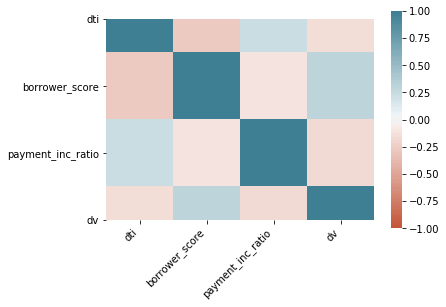

In [59]:
corr = loan_data[numcols].corr()
print("Correlation Matrix \n {}".format(corr))

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right')

#### This dataset do not have too much variables, therefore just did a light EDA. You can plot bar, histogram and bar/target, hist/targert. For this data just need to convert nominal to numerical

# Logistic regression

## Logistic Regression and the GLM
The package _scikit-learn_ has a specialised class for `LogisticRegression`. _Statsmodels_ has a more general method based on generalized linear model (GLM).

In scikit-learn, your target variable could be numerical or categorical.

In [60]:
predictors = ['purpose', 'dti', 'borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

loan, loan_test = train_test_split(loan_data, test_size=0.2)

X_train = pd.get_dummies(loan[predictors], prefix='', prefix_sep='', drop_first=True)
y_train = loan[outcome] 

X_test = pd.get_dummies(loan_test[predictors], prefix='', prefix_sep='', drop_first=True)
y_test = loan_test[outcome] 

#C=1e42,
logit_reg = LogisticRegression(penalty='l2', C=1e42, solver='liblinear')
logit_reg.fit(X_train, y_train)

print('intercept ', logit_reg.intercept_[0])
print('classes', logit_reg.classes_)
pd.DataFrame({'coeff': logit_reg.coef_[0]}, 
             index=X_train.columns)

intercept  -1.1246447734606824
classes ['default' 'paid off']


,coeff
dti,-0.024115
borrower_score,5.081635
payment_inc_ratio,-0.063141
debt_consolidation,-0.428964
home_improvement,-0.623048
major_purchase,-0.629035
medical,-1.602686
other,-0.893278
small_business,-1.321321


##### Task - Please fit the model second model with taget is a binary target 'dv', finish below cell in "Fit model"
##### Task continued - please output final model result as above example
##### QUESTION - What is the model fitted coefficent difference between the two model? Why?
##### ANSWER - The values of coefficents are close to each other while with minor difference. This is acceptable since the samples are not exactly the same.

In [61]:
predictors = ['purpose', 'dti', 'borrower_score', 'payment_inc_ratio']
outcome = 'dv'

loan, loan_test = train_test_split(loan_data, test_size=0.2)

X_train = pd.get_dummies(loan[predictors], prefix='', prefix_sep='', drop_first=True)
y_train = loan[outcome] 

X_test = pd.get_dummies(loan_test[predictors], prefix='', prefix_sep='', drop_first=True)
y_test = loan_test[outcome] 

#Fit model 
logit_reg2 = LogisticRegression(penalty='l2', C=1e42, solver='liblinear')
logit_reg2.fit(X_train, y_train)

print('intercept ', logit_reg2.intercept_[0])
print('classes', logit_reg2.classes_)
pd.DataFrame({'coeff': logit_reg2.coef_[0]}, 
             index=X_train.columns)

intercept  -0.9358869973960977
classes [0 1]


,coeff
dti,-0.022127
borrower_score,4.804939
payment_inc_ratio,-0.077917
debt_consolidation,-0.360766
home_improvement,-0.460723
major_purchase,-0.623099
medical,-1.309137
other,-0.661496
small_business,-1.042864


#### Predicted Values from Logistic Regression

In [36]:
pred_train = pd.DataFrame(logit_reg.predict_proba(X_train),
                    columns=logit_reg.classes_)
pred_test = pd.DataFrame(logit_reg.predict_proba(X_test),
                    columns=logit_reg.classes_)
print(pred_train.describe())

print(pred_test.describe())

           default     paid off
count  2400.000000  2400.000000
mean      0.480659     0.519341
std       0.172331     0.172331
min       0.060106     0.082365
25%       0.350414     0.392498
50%       0.475555     0.524445
75%       0.607502     0.649586
max       0.917635     0.939894
          default    paid off
count  600.000000  600.000000
mean     0.482323    0.517677
std      0.178400    0.178400
min      0.089437    0.107082
25%      0.345962    0.386499
50%      0.476694    0.523306
75%      0.613501    0.654038
max      0.892918    0.910563


In [37]:
pred_train = pd.DataFrame(logit_reg2.predict_proba(X_train),
                    columns=logit_reg2.classes_)
pred_test = pd.DataFrame(logit_reg2.predict_proba(X_test),
                    columns=logit_reg2.classes_)
print(pred_train.describe())

print(pred_test.describe())

                 0            1
count  2400.000000  2400.000000
mean      0.518750     0.481250
std       0.181733     0.181733
min       0.054633     0.068110
25%       0.383807     0.341630
50%       0.521410     0.478590
75%       0.658370     0.616193
max       0.931890     0.945367
                0           1
count  600.000000  600.000000
mean     0.516434    0.483566
std      0.190764    0.190764
min      0.090363    0.075100
25%      0.372635    0.330961
50%      0.518954    0.481046
75%      0.669039    0.627365
max      0.924900    0.909637


## GLM Model - logistic regression
For comparison, here the GLM model using _statsmodels_. This method requires that the outcome is mapped to numbers. 
##### use GLM (general linear model) with the binomial family to fit a logistic regression
##### Notice: use this GLM module you can fit a series of model by changing the link function which specified in the family option

In [62]:
logit_reg_sm = sm.GLM(y_train, sm.add_constant(X_train), 
                      family=sm.families.Binomial())
logit_result = logit_reg_sm.fit()
print(logit_result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                     dv   No. Observations:                 2400
Model:                            GLM   Df Residuals:                     2390
Model Family:                Binomial   Df Model:                            9
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1496.8
Date:                Tue, 23 Jun 2020   Deviance:                       2993.5
Time:                        22:49:51   Pearson chi2:                 2.38e+03
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.9354      0

# Evaluating Classification Models
## Confusion Matrix

###### Let's take a look how different predictin looks like

In [63]:
logit_reg2.predict(X_test)

array([1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,

In [64]:
logit_reg2.predict_proba(X_test)

array([[0.41593956, 0.58406044],
       [0.26571317, 0.73428683],
       [0.61850341, 0.38149659],
       ...,
       [0.57077309, 0.42922691],
       [0.47098791, 0.52901209],
       [0.34782629, 0.65217371]])

##### Manully create confusion matrix

In [65]:
# Confusion matrix
pred_y = logit_reg2.predict(X_test)
true_y = y_test 
true_pred = pd.DataFrame({'True': true_y, 'Pred': pred_y})
true_pred['Cnt'] = [1] *len(true_y)
confM=true_pred.groupby(['True', 'Pred']).size()

print("\nConfusion Matrix in 1D array\n {}".format(confM))

print("\nConfusion Matrix in 2 by 2 Table Format\n {}".format(pd.pivot_table(true_pred, values='Cnt', index=['True'],
                    columns=['Pred'], aggfunc=np.sum)))

conf_matorg = pd.DataFrame([[confM[1,1], confM[1,0]], [confM[0,1], confM[0,0]]],
                       index=['Y = default', 'Y = paid off'],
                       columns=['Yhat = default', 'Yhat = paid off'])
print("\nConfusion Matrix in 2 by 2 Re-orgnized Table Format\n {}".format(conf_matorg))


Confusion Matrix in 1D array
 True  Pred
0     0       190
      1       121
1     0       116
      1       173
dtype: int64

Confusion Matrix in 2 by 2 Table Format
 Pred    0    1
True          
0     190  121
1     116  173

Confusion Matrix in 2 by 2 Re-orgnized Table Format
               Yhat = default  Yhat = paid off
Y = default              173              116
Y = paid off             121              190


##### Acouple existing function in packages provice confusion matrix

In [66]:
print(confusion_matrix(y_test, logit_reg2.predict(X_test)))

[[190 121]
 [116 173]]


The package _dmba_ contains the function `classificationSummary` that prints confusion matrix and accuracy for a classification model. 

In [67]:
classificationSummary(y_test, logit_reg2.predict(X_test), 
                      class_names=logit_reg2.classes_)

Confusion Matrix (Accuracy 0.6050)

       Prediction
Actual   0   1
     0 190 121
     1 116 173


## Precision, Recall, and Specificity
#### Precision = tp/(tp+fp)
#### Recall (Sensitivity) = tp/(tp+fn)
#### Specificity = tn/(tn+fp)

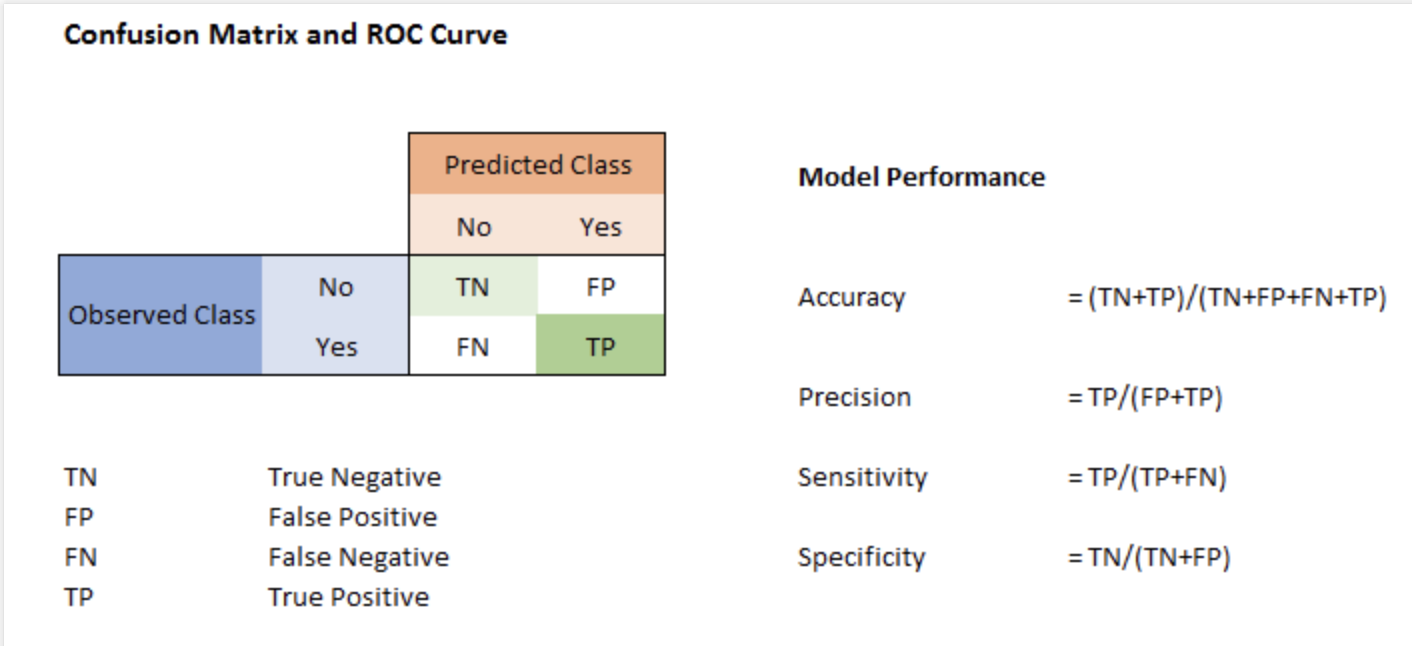

##### Task - use "tn, fp, fn, tp" to calculate "Precision,Recall,Specificity"

In [74]:
tn, fp, fn, tp = confusion_matrix(y_test, logit_reg2.predict(X_test)).ravel()
print('Precision:   {}'.format(tp/(fp+tp))) 
print('Recall:     {}'.format(tp/(tp+fn)))
print('Specificity: {}'.format(tn/(tn+fp)))

Precision:   0.5884353741496599
Recall:     0.5986159169550173
Specificity: 0.6109324758842444


##### Task - use "conf_mat" to calculate "Precision,Recball,Specificity"

In [75]:
conf_mat = confusion_matrix(y_test, logit_reg2.predict(X_test))
print('Precision', (conf_mat[1][1])/(conf_mat[0][1]+conf_mat[1][1]))
print('Recall', conf_mat[1][1]/conf_mat[1].sum())
print('Specificity', conf_mat[0][0]/conf_mat[0].sum())

Precision 0.5884353741496599
Recall 0.5986159169550173
Specificity 0.6109324758842444


The _scikit-learn_ function `precision_recall_fscore_support` returns
precision, recall, fbeta_score and support. 

In [76]:
precision_recall_fscore_support(y_test, logit_reg2.predict(X_test), 
                                labels=[0, 1])

(array([0.62091503, 0.58843537]),
 array([0.61093248, 0.59861592]),
 array([0.61588331, 0.59348199]),
 array([311, 289], dtype=int64))

In [77]:
from sklearn.metrics import classification_report
target_names = ['paid off', 'default']
print(classification_report(true_y, pred_y, target_names=target_names))

              precision    recall  f1-score   support

    paid off       0.62      0.61      0.62       311
     default       0.59      0.60      0.59       289

    accuracy                           0.60       600
   macro avg       0.60      0.60      0.60       600
weighted avg       0.61      0.60      0.61       600



## ROC Curve
The function `roc_curve` in _Scikit-learn_ calculates all the information that is required for plotting a ROC curve.

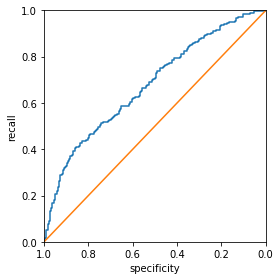

In [81]:
fpr, tpr, thresholds = roc_curve(y_test, (logit_reg2.predict_proba(X_test)[:, 1]), 
                                 pos_label=1)
roc_df = pd.DataFrame({'recall': tpr, 'specificity': 1 - fpr})

ax = roc_df.plot(x='specificity', y='recall', figsize=(4, 4), legend=False)
ax.set_ylim(0, 1)
ax.set_xlim(1, 0)
ax.plot((1, 0), (0, 1))
ax.set_xlabel('specificity')
ax.set_ylabel('recall')

plt.tight_layout()
plt.show()

## AUC
Accuracy can easily be calculated using the _scikit-learn_ function `accuracy_score`.

In [82]:
print(np.sum(roc_df.recall[:-1] * np.diff(1 - roc_df.specificity)))
print(roc_auc_score(y_test, (logit_reg2.predict_proba(X_test)[:, 1])))

0.6756416960580336
0.6756416960580336


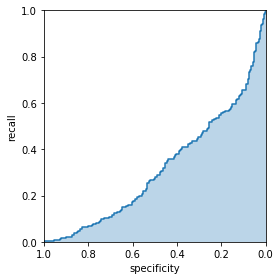

In [83]:
fpr, tpr, thresholds = roc_curve(y_test, (logit_reg.predict_proba(X_test)[:,0]), 
                                 pos_label=1)
roc_df = pd.DataFrame({'recall': tpr, 'specificity': 1 - fpr})

ax = roc_df.plot(x='specificity', y='recall', figsize=(4, 4), legend=False)
ax.set_ylim(0, 1)
ax.set_xlim(1, 0)
# ax.plot((1, 0), (0, 1))
ax.set_xlabel('specificity')
ax.set_ylabel('recall')
ax.fill_between(roc_df.specificity, 0, roc_df.recall, alpha=0.3)


plt.tight_layout()
plt.show()

## F1 Score 
### F1 = 2 * Precision* Recall/(Precision + Recall)

##### Task - Calculate F1 score for 'default'

In [85]:
print('Precision:   {}'.format(tp/(fp+tp))) 
pre = tp/(fp+tp)
print('Recall:     {}'.format(tp/(tp+fn)))
rec = tp/(tp+fn)
print('F1 SCORE for Default:  {}'.format(2*pre*rec/(pre+rec)))

Precision:   0.5884353741496599
Recall:     0.5986159169550173
F1 SCORE for Default:  0.5934819897084047
